In [6]:
import json
import matplotlib.pyplot as plt
import polars as pl

from typing import Any
from privacy_and_grokking.path_keeper import get_path_keeper

In [7]:
RUN_ID = "v1.0.0"
MODELS = ["MLP_V1", "MLP_GROK_V1", "CNN_V1", "CNN_GROK_V1"]

In [8]:
pk = get_path_keeper()
pk.set_params({"run_id": RUN_ID})

In [9]:
def flatten_dict(d: dict[str, Any], parent_key: str = "", sep: str = "_") -> dict[str, Any]:
    items: list[tuple[str, Any]] = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [10]:
dfs = {}
for model in MODELS:
    pk.set_params({"model": model})
    metrics: list[dict] = json.loads(pk.TRAIN_METRICS.read_text())
    metrics = [flatten_dict(m) for m in metrics]
    df = pl.DataFrame(metrics)
    dfs[model] = df

In [11]:
dfs[list(dfs.keys())[0]].head()

step,train_loss,train_accuracy,test_loss,test_accuracy,norm,last_layer_norm
i64,f64,f64,f64,f64,f64,f64
0,0.000589,0.095183,0.000591,0.0907,11.738787,1.818007
1,0.000443,0.253417,0.000444,0.2716,11.74358,1.816155
2,0.000418,0.422733,0.000418,0.4305,11.753071,1.814658
3,0.000368,0.54335,0.000367,0.5455,11.762148,1.812538
4,0.000337,0.637283,0.000336,0.6401,11.772974,1.810915


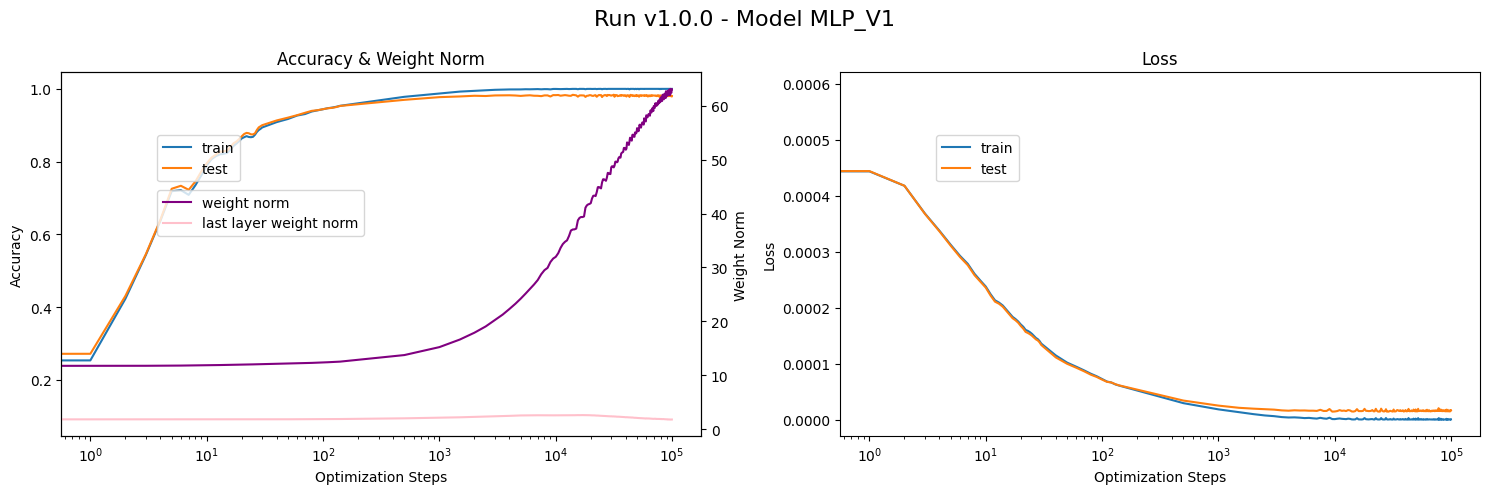

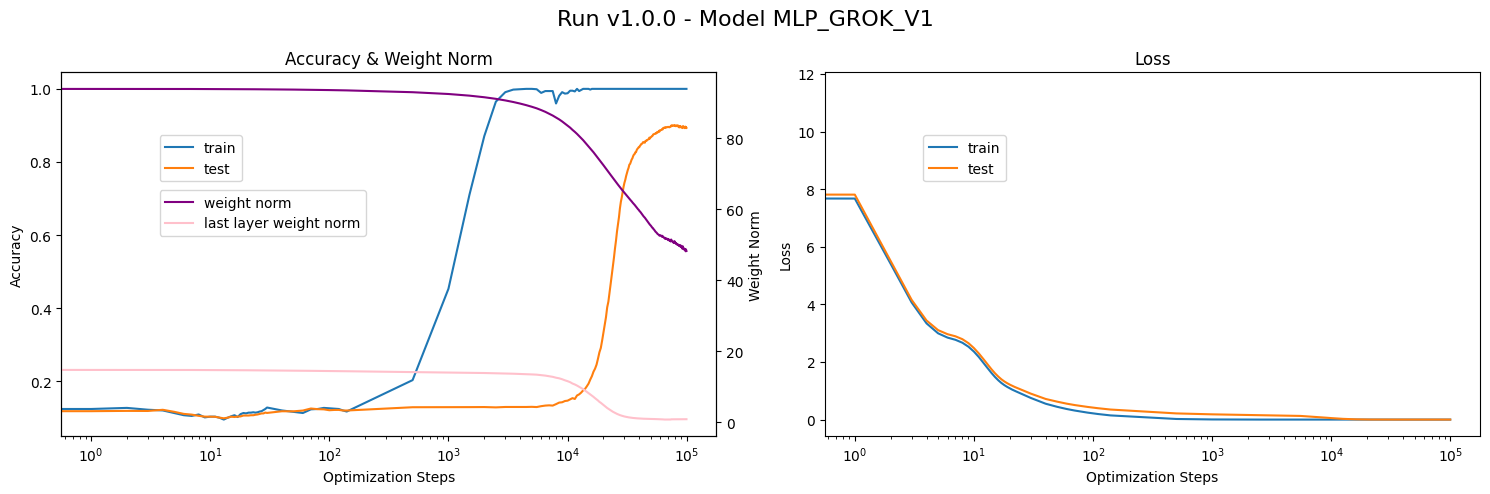

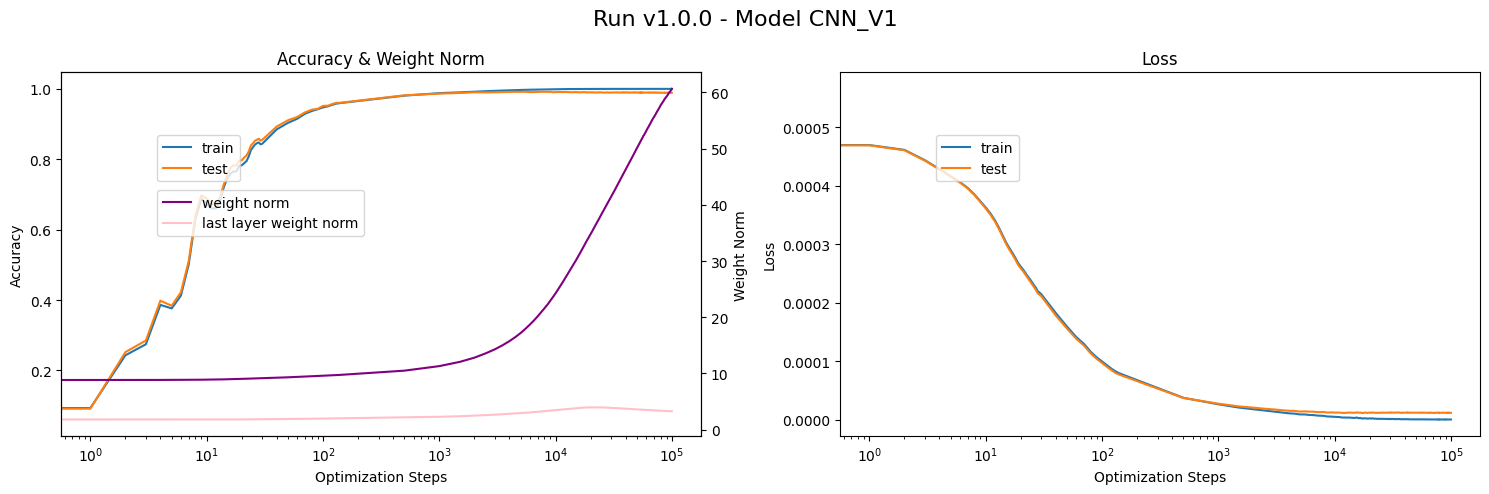

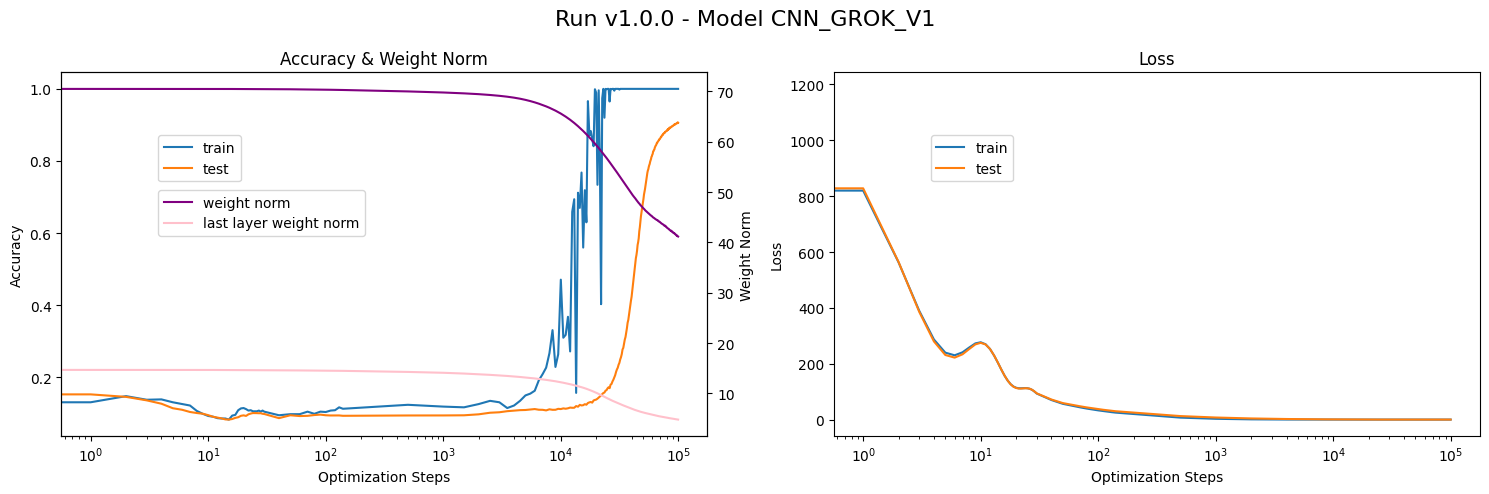

In [12]:
for model, df in dfs.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Left subplot: Accuracy and Weight Norm
    ax1.set_xlabel("Optimization Steps")
    ax1.set_xscale("log")
    ax1.set_ylabel("Accuracy")
    ax1.plot(df["step"], df["train_accuracy"], label="train")
    ax1.plot(df["step"], df["test_accuracy"], label="test")
    ax1.legend(loc=(0.15, 0.7))
    
    ax1_twin = ax1.twinx()
    ax1_twin.set_ylabel("Weight Norm")
    ax1_twin.plot(df["step"], df["norm"], color="purple", label="weight norm")
    ax1_twin.plot(df["step"], df["last_layer_norm"], color="pink", label="last layer weight norm")
    ax1_twin.legend(loc=(0.15, 0.55))
    
    ax1.set_title("Accuracy & Weight Norm")
    
    # Right subplot: Loss
    ax2.set_xlabel("Optimization Steps")
    ax2.set_xscale("log")
    ax2.set_ylabel("Loss")
    ax2.plot(df["step"], df["train_loss"], label="train")
    ax2.plot(df["step"], df["test_loss"], label="test")
    ax2.legend(loc=(0.15, 0.7))
    ax2.set_title("Loss")
    
    # Overall title
    fig.suptitle("Run {} - Model {}".format(RUN_ID, model), fontsize=16)
    plt.tight_layout()
    plt.show()

In [13]:
# Calculate correct logits size over time for all models
import numpy as np

# Update MODELS to include all available models
MODELS = ["MLP_V1", "MLP_GROK_V1", "CNN_V1", "CNN_GROK_V1"]

def process_logits_data(df_data, dataset_name):
    """Process logits data to extract correct and wrong logits"""
    df_with_logits = df_data.with_columns([
        # Correct logit - extract the logit corresponding to the correct label
        pl.concat_list([f"logit_{i}" for i in range(10)]).list.get(pl.col("correct_label")).alias("correct_logit"),
        
        # Calculate average wrong logits
        pl.struct(["correct_label"] + [f"logit_{i}" for i in range(10)])
        .map_elements(
            lambda row: float(np.mean([row[f"logit_{i}"] for i in range(10) if i != row["correct_label"]])),
            return_dtype=pl.Float64
        )
        .alias("avg_wrong_logit")
    ])
    
    # Group by step and calculate statistics
    logits_by_step = (
        df_with_logits
        .group_by("step")
        .agg([
            pl.col("correct_logit").mean().alias("avg_correct_logit"),
            pl.col("correct_logit").std().alias("std_correct_logit"),
            pl.col("avg_wrong_logit").mean().alias("avg_wrong_logit"),
            pl.col("avg_wrong_logit").std().alias("std_wrong_logit"),
            pl.col("correct_logit").count().alias("count")
        ])
        .sort("step")
    )
    
    return logits_by_step

In [14]:
for model in MODELS:
    try:
        pk.set_params({"model": model, "step": "*"})

        df_train = pl.read_parquet(pk.TRAIN_LOGITS, glob=True)
        df_test = pl.read_parquet(pk.TEST_LOGITS, glob=True)

        train_logits = process_logits_data(df_train, "train")
        test_logits = process_logits_data(df_test, "test")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Train
        steps_train = train_logits["step"].to_numpy()
        avg_correct_train = train_logits["avg_correct_logit"].to_numpy()
        std_correct_train = train_logits["std_correct_logit"].to_numpy()
        avg_wrong_train = train_logits["avg_wrong_logit"].to_numpy()
        std_wrong_train = train_logits["std_wrong_logit"].to_numpy()

        ax1.plot(steps_train, avg_correct_train, "b-", linewidth=2, label="Average Correct Logit")
        ax1.fill_between(steps_train, avg_correct_train - std_correct_train, avg_correct_train + std_correct_train, 
                        alpha=0.3, color="blue", label="Correct Logit ±1 Std")
        ax1.plot(steps_train, avg_wrong_train, "r-", linewidth=2, label="Average Wrong Logits")
        ax1.fill_between(steps_train, avg_wrong_train - std_wrong_train, avg_wrong_train + std_wrong_train, 
                        alpha=0.3, color="red", label="Wrong Logits ±1 Std")
        
        ax1.set_xlabel("Optimization Steps")
        ax1.set_ylabel("Logit Size")
        ax1.set_title("Training Data - Correct vs Wrong Logits")
        ax1.set_xscale("log")
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Test
        steps_test = test_logits["step"].to_numpy()
        avg_correct_test = test_logits["avg_correct_logit"].to_numpy()
        std_correct_test = test_logits["std_correct_logit"].to_numpy()
        avg_wrong_test = test_logits["avg_wrong_logit"].to_numpy()
        std_wrong_test = test_logits["std_wrong_logit"].to_numpy()
        
        ax2.plot(steps_test, avg_correct_test, "b-", linewidth=2, label="Average Correct Logit")
        ax2.fill_between(steps_test, avg_correct_test - std_correct_test, avg_correct_test + std_correct_test, 
                        alpha=0.3, color="blue", label="Correct Logit ±1 Std")
        ax2.plot(steps_test, avg_wrong_test, "r-", linewidth=2, label="Average Wrong Logits")
        ax2.fill_between(steps_test, avg_wrong_test - std_wrong_test, avg_wrong_test + std_wrong_test, 
                        alpha=0.3, color="red", label="Wrong Logits ±1 Std")
        
        ax2.set_xlabel("Optimization Steps")
        ax2.set_ylabel("Logit Size")
        ax2.set_title("Test Data - Correct vs Wrong Logits")
        ax2.set_xscale("log")
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Overall title
        fig.suptitle(f"Logits Analysis - {RUN_ID} {model}", fontsize=16)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {model}: {e}")
        continue

Error processing MLP_V1: failed to retrieve first file schema (parquet): expanded paths were empty (path expansion input: 'paths: [Local("/Users/ronholzapfel/Documents/private/privacy-and-grokking/data/runs/v1.0.0/MLP_V1/checkpoints/*/train_logits.parquet")]', glob: true). Hint: passing a schema can allow this scan to succeed with an empty DataFrame.

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'

Error processing MLP_GROK_V1: failed to retrieve first file schema (parquet): expanded paths were empty (path expansion input: 'paths: [Local("/Users/ronholzapfel/Documents/private/privacy-and-grokking/data/runs/v1.0.0/MLP_GROK_V1/checkpoints/*/train_logits.parquet")]', glob: true). Hint: passing a schema can allow this scan to succeed with an empty DataFrame.

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'

Error processing CNN_V1: failed to retrieve first file schema (parquet): expanded paths were empty (path exp

In [15]:
for model in MODELS:
    try:
        pk.set_params({"model": model, "step": "*"})

        df_train = pl.read_parquet(pk.TRAIN_LOGITS, glob=True)
        df_test = pl.read_parquet(pk.TEST_LOGITS, glob=True)

        train_logits = process_logits_data(df_train, "train")
        test_logits = process_logits_data(df_test, "test")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        steps = train_logits["step"].to_numpy()
        # Correct logits
        avg_correct_train = train_logits["avg_correct_logit"].to_numpy()
        std_correct_train = train_logits["std_correct_logit"].to_numpy()
        avg_correct_test = test_logits["avg_correct_logit"].to_numpy()
        std_correct_test = test_logits["std_correct_logit"].to_numpy()

        ax1.plot(steps, avg_correct_train, "b-", linewidth=2, label="Train Average")
        ax1.fill_between(steps, avg_correct_train - std_correct_train, avg_correct_train + std_correct_train, 
                        alpha=0.3, color="blue", label="Train ±1 Std")
        ax1.plot(steps, avg_correct_test, "r-", linewidth=2, label="Test Average")
        ax1.fill_between(steps, avg_correct_test - std_correct_test, avg_correct_test + std_correct_test, 
                        alpha=0.3, color="red", label="Test ±1 Std")
        
        ax1.set_xlabel("Optimization Steps")
        ax1.set_ylabel("Logit Size")
        ax1.set_title("Correct Logits")
        ax1.set_xscale("log")
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Wrong logits
        avg_wrong_train = train_logits["avg_wrong_logit"].to_numpy()
        std_wrong_train = train_logits["std_wrong_logit"].to_numpy()
        avg_wrong_test = test_logits["avg_wrong_logit"].to_numpy()
        std_wrong_test = test_logits["std_wrong_logit"].to_numpy()
        
        ax2.plot(steps, avg_wrong_train, "b-", linewidth=2, label="Train Average")
        ax2.fill_between(steps, avg_wrong_train - std_wrong_train, avg_wrong_train + std_wrong_train, 
                        alpha=0.3, color="blue", label="Train ±1 Std")
        ax2.plot(steps, avg_wrong_test, "r-", linewidth=2, label="Test Average")
        ax2.fill_between(steps, avg_wrong_test - std_wrong_test, avg_wrong_test + std_wrong_test, 
                        alpha=0.3, color="red", label="Test ±1 Std")
        
        ax2.set_xlabel("Optimization Steps")
        ax2.set_ylabel("Logit Size")
        ax2.set_title("Wrong Logits")
        ax2.set_xscale("log")
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Overall title
        fig.suptitle(f"Logits Analysis - {RUN_ID} {model}", fontsize=16)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {model}: {e}")
        continue

Error processing MLP_V1: failed to retrieve first file schema (parquet): expanded paths were empty (path expansion input: 'paths: [Local("/Users/ronholzapfel/Documents/private/privacy-and-grokking/data/runs/v1.0.0/MLP_V1/checkpoints/*/train_logits.parquet")]', glob: true). Hint: passing a schema can allow this scan to succeed with an empty DataFrame.

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'

Error processing MLP_GROK_V1: failed to retrieve first file schema (parquet): expanded paths were empty (path expansion input: 'paths: [Local("/Users/ronholzapfel/Documents/private/privacy-and-grokking/data/runs/v1.0.0/MLP_GROK_V1/checkpoints/*/train_logits.parquet")]', glob: true). Hint: passing a schema can allow this scan to succeed with an empty DataFrame.

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'

Error processing CNN_V1: failed to retrieve first file schema (parquet): expanded paths were empty (path exp